In [1]:
using Flux

┌ Warning: This version of CUDA.jl only supports NVIDIA drivers for CUDA 10.1 or higher (yours is for CUDA 9.1.0)
└ @ CUDA C:\Users\Fluid3\.julia\packages\CUDA\M4jkK\src\initialization.jl:100


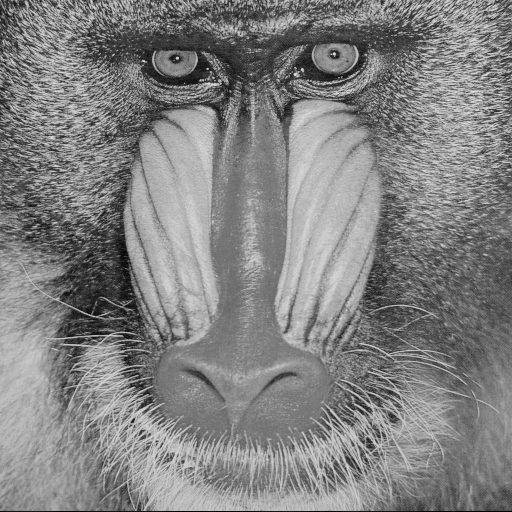

In [2]:
import TestImages: testimage
import ImageView: imshow
import Images: Gray
img = testimage("mandrill")
im0 = 1*Gray.(img)

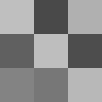

In [3]:
import ImageTransformations: imresize
im3 = imresize(im0, 3, 3)

In [4]:
# we are going to do the same or similar ops for a small matrix and for a large one
# and this way if any problems arise, we'll know if it's logic or size
m_im0 = convert(Matrix{Float32}, im0)
m_im3 = convert(Matrix{Float32}, im3)

3×3 Matrix{Float32}:
 0.749673  0.286601  0.689869
 0.378105  0.743137  0.302288
 0.515142  0.466993  0.72146

In [9]:
function warp3(x, y, p) # 0:31
    knob = p[:knob]
    clip(n, nsize) = max(min(nsize, n), 1)
    (xnew, ynew) =
        # clip(convert(Int, floor(x - 10 * (knob / 32) * sin(y/4))), xsize), y), # currently unused variant
        # clip(convert(Int, floor(x + 10 * ((knob - 16) / 16) * sin(y/4))), xsize), y) # normalize to get +/-
        (clip(x + 10 * ((knob - 16) / 16) * sin(y/4), p[:xsize]), y)
    xnew, ynew
end

warp3 (generic function with 1 method)

In [10]:
function apply_warp(warp, im, p)
    (xsize, ysize) = size(im)
    p[:xsize] = xsize
    p[:ysize] = ysize
    function linear_interpolation(x_y)
        # a rough draft, this can be improved; works on im
        x = x_y[1]
        y = x_y[2]
        dx=mod(x,1)
        dy=mod(y,1)
        x_left = floor(Int,x)
        y_left = floor(Int,y)
        x_right = min(x_left + 1, xsize)
        y_right = min(y_left + 1, ysize)
        im[x_left,y_left]*(1-dx)*(1-dy) + im[x_left,y_right]*(1-dx)*dy + im[x_right,y_left]*dx*(1-dy) + im[x_right, y_right]*dx*dy
    end
    [linear_interpolation(warp(x,y,p)) for x in 1:xsize, y in 1:ysize]
end

apply_warp (generic function with 1 method)

In [11]:
pars = Dict(:knob=>0, :dummy=>0.0)
# at least one of the above should be float and not integer, so that the dictionary type is
# Dict{Symbol, Real}  and not Dict{Symbol, Int64}

Dict{Symbol, Real} with 2 entries:
  :dummy => 0.0
  :knob  => 0

In [12]:
m_im0_warped = im3 = apply_warp(warp3, m_im0, pars)

512×512 Matrix{Float64}:
 0.568627  0.219608  0.192157  0.34902   …  0.443137  0.6       0.694118
 0.568627  0.219608  0.192157  0.34902      0.443137  0.6       0.694118
 0.568627  0.219608  0.192157  0.34902      0.443137  0.6       0.694118
 0.508812  0.219608  0.192157  0.34902      0.443137  0.6       0.694118
 0.374461  0.219608  0.192157  0.34902      0.443137  0.6       0.694118
 0.289585  0.255916  0.192157  0.34902   …  0.443137  0.6       0.694118
 0.311433  0.406567  0.192157  0.34902      0.443137  0.6       0.694118
 0.330864  0.464809  0.185676  0.34902      0.443137  0.6       0.694118
 0.241128  0.522038  0.161183  0.34902      0.443137  0.6       0.533097
 0.148002  0.441317  0.215675  0.298524     0.443137  0.595302  0.353947
 0.178914  0.277868  0.399191  0.214545  …  0.466496  0.512663  0.283585
 0.18434   0.2       0.537088  0.184983     0.468583  0.329828  0.324055
 0.138707  0.197579  0.605528  0.192826     0.355058  0.299991  0.634525
 ⋮                        

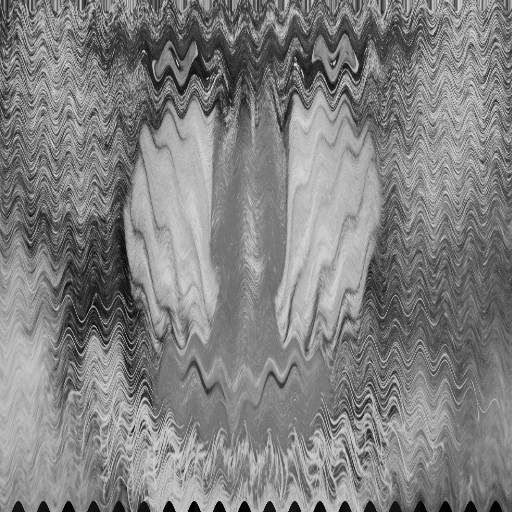

In [13]:
Gray.(m_im0_warped)

In [27]:
# scale image so that all points brightness are between 0 and 1, and that full range is used
# we are going to use this on plain matrices and not on images, and we might need explicit broadcasting
function normalize_image(im)
    im_res = im .- minimum(im)
    return (1/maximum(im_res))*im_res
end

normalize_image (generic function with 1 method)

In [15]:
import LinearAlgebra: transpose

In [16]:
norm_columns(f, x) = f.(x) ./ (sum(f.(x), dims=1))

norm_columns (generic function with 1 method)

In [17]:
# this version returns an ordinary matrix, does not try to produce an image
# this is different in this refactor
norm_image_columns(f, x) = normalize_image(norm_columns(f, x))

norm_image_columns (generic function with 1 method)

In [22]:
tmp = norm_columns(x -> x+1, m_im3)

3×3 Matrix{Float32}:
 0.376848  0.286119  0.358508
 0.296819  0.387645  0.276282
 0.326334  0.326235  0.36521

In [32]:
tmp1 = tmp .- minimum(tmp)

3×3 Matrix{Float32}:
 0.100566   0.00983715  0.082226
 0.0205365  0.111363    0.0
 0.0500518  0.0499534   0.0889279

In [33]:
(1/maximum(tmp1))

8.979617f0

In [34]:
(1/maximum(tmp1))*tmp1

3×3 Matrix{Float32}:
 0.903041  0.0883338  0.738358
 0.18441   1.0        0.0
 0.449446  0.448563   0.798539

In [35]:
normalize_image(tmp)

3×3 Matrix{Float32}:
 0.903041  0.0883338  0.738358
 0.18441   1.0        0.0
 0.449446  0.448563   0.798539

In [36]:
m_im3_norm = norm_image_columns(x -> x+1, m_im3)

3×3 Matrix{Float32}:
 0.903041  0.0883338  0.738358
 0.18441   1.0        0.0
 0.449446  0.448563   0.798539

In [37]:
m_im0_norm = norm_image_columns(x -> x+1, m_im0)

512×512 Matrix{Float32}:
 0.594109   0.258764   0.228277   0.376406   …  0.554609  0.711567  0.801687
 0.484139   0.429719   0.194201   0.293322      0.622855  0.695544  0.594119
 0.336248   0.479106   0.216918   0.214014      0.50242   0.451202  0.418485
 0.313495   0.562684   0.402442   0.221567      0.394029  0.399129  0.374576
 0.374169   0.509498   0.54253    0.22912       0.337826  0.419157  0.438443
 0.355208   0.334744   0.644758   0.270662   …  0.442203  0.707561  0.821646
 0.207317   0.239769   0.550103   0.531244      0.843652  0.891819  0.749795
 0.169396   0.239769   0.463021   0.618104      0.747304  0.579381  0.646011
 0.260406   0.228372   0.25478    0.482149      0.642927  0.723584  0.582144
 0.188356   0.167588   0.224491   0.281992      0.361913  0.423162  0.638028
 0.169396   0.209377   0.258566   0.180026   …  0.361913  0.391118  0.366593
 0.169396   0.224573   0.338076   0.176249      0.458261  0.395123  0.394534
 0.180772   0.300553   0.383511   0.285769      0.4

In [38]:
transposed_product(x) = normalize_image(transpose(x)*x)

transposed_product (generic function with 1 method)

In [39]:
p_m_im3_norm = transposed_product(m_im3_norm)

3×3 Matrix{Float32}:
 0.79949    0.0539301  0.766617
 0.0539301  1.0        0.0
 0.766617   0.0        0.966681

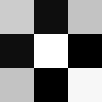

In [40]:
Gray.(p_m_im3_norm)

In [41]:
p_m_im0_norm = transposed_product(m_im0_norm)

512×512 Matrix{Float32}:
 0.700166  0.649225  0.582028  0.539729  …  0.290948  0.280434  0.278963
 0.649225  0.720717  0.655016  0.579452     0.279161  0.266794  0.266486
 0.582028  0.655016  0.705407  0.635641     0.282356  0.271387  0.270611
 0.539729  0.579452  0.635641  0.70149      0.291333  0.274358  0.270634
 0.543259  0.568641  0.573838  0.63398      0.283634  0.272124  0.269107
 0.536378  0.562285  0.560459  0.579527  …  0.290106  0.264459  0.258168
 0.556486  0.574343  0.548719  0.563079     0.28191   0.25571   0.247531
 0.533078  0.558498  0.539429  0.544571     0.26464   0.245192  0.24628
 0.504532  0.52071   0.510141  0.531501     0.255971  0.245249  0.251247
 0.500537  0.506557  0.49794   0.514166     0.252797  0.258467  0.270269
 0.509082  0.51311   0.502024  0.489594  …  0.266599  0.277523  0.281833
 0.514124  0.528676  0.51574   0.489787     0.275499  0.26578   0.262992
 0.492361  0.509135  0.503046  0.487629     0.274559  0.262621  0.255816
 ⋮                         

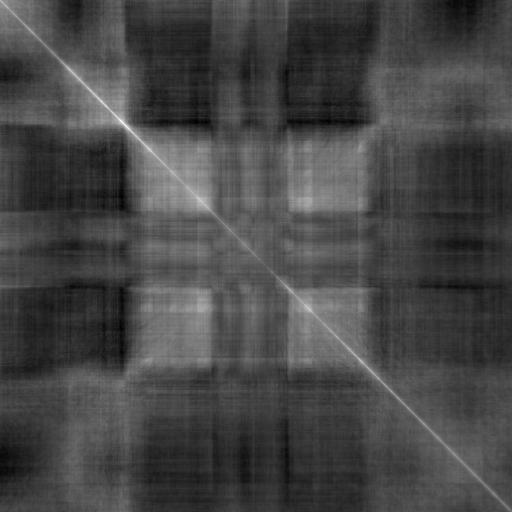

In [42]:
Gray.(p_m_im0_norm)

In [43]:
m_im3

3×3 Matrix{Float32}:
 0.749673  0.286601  0.689869
 0.378105  0.743137  0.302288
 0.515142  0.466993  0.72146

In [45]:
m_im3[3,2]

0.46699348f0

In [46]:
m_im3_warped = deepcopy(m_im3)

3×3 Matrix{Float32}:
 0.749673  0.286601  0.689869
 0.378105  0.743137  0.302288
 0.515142  0.466993  0.72146

In [47]:
m_im3_warped[1,2] = m_im3_warped[2,2]
m_im3_warped[2,2] = m_im3_warped[3,2]
m_im3_warped[3,2] = 0

0

In [48]:
m_im3_warped

3×3 Matrix{Float32}:
 0.749673  0.743137  0.689869
 0.378105  0.466993  0.302288
 0.515142  0.0       0.72146

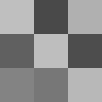

In [49]:
Gray.(m_im3)

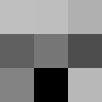

In [50]:
Gray.(m_im3_warped)

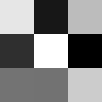

In [51]:
Gray.(m_im3_norm)

In [52]:
m_im3_warped_norm = norm_image_columns(x -> x+1, m_im3_warped)

3×3 Matrix{Float32}:
 0.789326  1.0       0.685426
 0.335934  0.628408  0.219587
 0.503148  0.0       0.723395

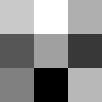

In [53]:
Gray.(m_im3_warped_norm)

In [54]:
p_m_im3_warped_norm = transposed_product(m_im3_warped_norm)

3×3 Matrix{Float32}:
 0.289825  0.309745  0.271838
 0.309745  1.0       0.0
 0.271838  0.0       0.38131

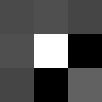

In [55]:
Gray.(p_m_im3_warped_norm)

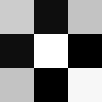

In [56]:
Gray.(p_m_im3_norm)

In [57]:
m_im0_warped_norm = norm_image_columns(x -> x+1, m_im0_warped)

512×512 Matrix{Float64}:
 0.595443  0.259179  0.229673  0.378513  …  0.553927  0.709128  0.799002
 0.595443  0.259179  0.229673  0.378513     0.553927  0.709128  0.799002
 0.595443  0.259179  0.229673  0.378513     0.553927  0.709128  0.799002
 0.53705   0.259179  0.229673  0.378513     0.553927  0.709128  0.799002
 0.405894  0.259179  0.229673  0.378513     0.553927  0.709128  0.799002
 0.323036  0.294756  0.229673  0.378513  …  0.553927  0.709128  0.799002
 0.344364  0.442376  0.229673  0.378513     0.553927  0.709128  0.799002
 0.363333  0.499446  0.223337  0.378513     0.553927  0.709128  0.799002
 0.275731  0.555522  0.19939   0.378513     0.553927  0.709128  0.634106
 0.184819  0.476426  0.252666  0.329313     0.553927  0.704297  0.450645
 0.214996  0.316267  0.432087  0.247489  …  0.578041  0.619334  0.378589
 0.220294  0.239966  0.566908  0.218686     0.580195  0.431355  0.420033
 0.175745  0.237594  0.633821  0.226327     0.462998  0.400678  0.737975
 ⋮                        

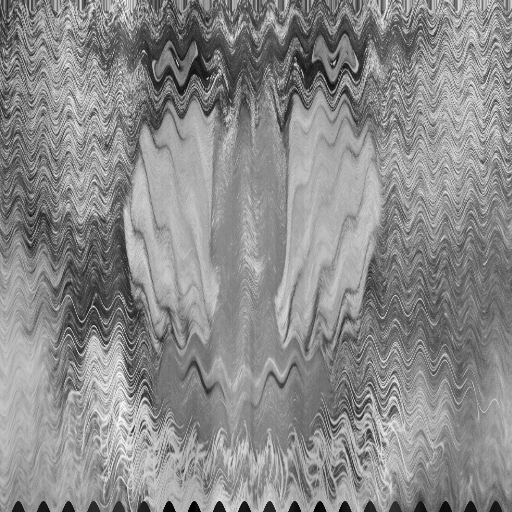

In [58]:
Gray.(m_im0_warped_norm)

In [59]:
p_m_im0_warped_norm = transposed_product(m_im0_warped_norm)

512×512 Matrix{Float64}:
 0.669311  0.584535  0.572173  0.552845  …  0.284581  0.275179  0.283276
 0.584535  0.716862  0.595695  0.578578     0.29765   0.268683  0.273719
 0.572173  0.595695  0.710956  0.576542     0.280736  0.266551  0.264784
 0.552845  0.578578  0.576542  0.674866     0.292628  0.278145  0.265065
 0.551385  0.564336  0.564985  0.578561     0.298222  0.284138  0.284079
 0.546966  0.568356  0.575928  0.575173  …  0.301359  0.274288  0.280002
 0.564323  0.586319  0.594799  0.580559     0.292327  0.264085  0.273857
 0.546884  0.592824  0.589149  0.578591     0.288131  0.245897  0.260751
 0.51934   0.573673  0.545996  0.544961     0.282458  0.247429  0.25664
 0.507715  0.546552  0.528018  0.518404     0.271142  0.259321  0.253164
 0.514793  0.526025  0.529024  0.515247  …  0.266063  0.259653  0.265294
 0.520846  0.532841  0.542403  0.510905     0.275565  0.251565  0.259405
 0.501864  0.5204    0.509853  0.518335     0.263533  0.255126  0.25622
 ⋮                          

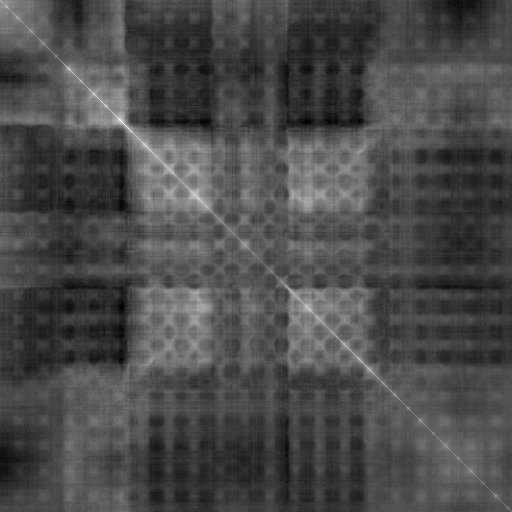

In [60]:
Gray.(p_m_im0_warped_norm)

In [61]:
import LinearAlgebra: norm

In [62]:
value3(A) = transposed_product(norm_image_columns(x -> x+1, A))

value3 (generic function with 1 method)

In [63]:
loss(x, y) = norm(value3(x) - y)

loss (generic function with 1 method)

In [64]:
loss(m_im3, p_m_im3_warped_norm)

1.1058546f0

In [65]:
grads = gradient(()->loss(m_im3, p_m_im3_warped_norm), params(m_im3))

Grads(...)

In [67]:
g_m_im3 = grads[m_im3]

3×3 Matrix{Float32}:
  1.70159    3.26869    1.1471
 -2.59416   -3.25235   -2.04516
  0.394542   0.997814   0.421118

In [73]:
loss(m_im3 .- 0.05*g_m_im3, p_m_im3_warped_norm)

0.2981863111536775

In [74]:
new_m_im3 = m_im3 .- 0.05*g_m_im3

3×3 Matrix{Float64}:
 0.664594  0.123167  0.632514
 0.507812  0.905755  0.404546
 0.495415  0.417103  0.700404

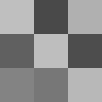

In [75]:
Gray.(m_im3)

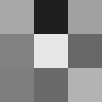

In [76]:
Gray.(new_m_im3)

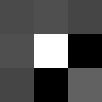

In [77]:
# target
Gray.(p_m_im3_warped_norm)

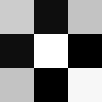

In [78]:
# old value
Gray.(value3(m_im3))

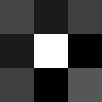

In [79]:
# new value
Gray.(value3(new_m_im3))

In [80]:
# THAT WAS RATHER NICE! The new value is indeed closer to target compared to the old one
# And that optimization step (coefficient 0.05 was manually experimentally determined, started with 0.01,
# and gradually increasing it till increase became counter-productive, basically manual optimization
# along 1D) did result in a different structure.

# Now let's do that for the full image

In [81]:
loss(m_im0, p_m_im0_warped_norm)

20.39865222030749

In [82]:
grads_large = gradient(()->loss(m_im0, p_m_im0_warped_norm), params(m_im0))

Grads(...)

In [83]:
# that was instant computation

In [84]:
g_m_im0 = grads_large[m_im0]

512×512 Matrix{Float64}:
 -3.25609e-5    0.00054444    0.000836175  …  -0.000713093  -0.00119704
 -3.29761e-5    0.000546671   0.00052575       0.00017423   -0.000258225
 -0.000248397   0.000336838   0.000176797      0.00028079   -5.5818e-5
 -0.00042219    0.000205706   0.000156452      0.000362991   0.000198234
 -0.000404119   3.14928e-5    0.000271503      0.000509889   0.000510188
 -0.000586425  -0.000193112   0.00057968   …   0.0010272     0.000930229
 -0.000511232   1.3709e-5     0.000984898      0.00250941    0.00218226
 -0.000519427  -7.78149e-5    0.000872445      0.00251798    0.0021323
 -0.000598552  -0.000127619   0.000413524      0.00189765    0.00161444
 -0.000310217   0.000133875   0.000481317      0.00089437    0.000754028
 -2.56479e-5    0.0005671     0.000942142  …   0.000927282   0.000629196
 -4.31686e-5    0.00060372    0.000952447      0.00157936    0.0012232
  0.000205387   0.000746853   0.00110652       0.00188625    0.00142567
  ⋮                                 

In [85]:
# that was instant as well

In [105]:
loss(m_im0 .- 0.0031*g_m_im0, p_m_im0_warped_norm)

18.3694653228201

In [106]:
# 0.0031 gives approximately the best loss after one step (manual search along 1D)
new_m_im0 = m_im0 .- 0.0031*g_m_im0

512×512 Matrix{Float64}:
 0.568628  0.219606   0.192154  0.34902    …  0.443136   0.600002   0.694121
 0.454902  0.396077   0.156861  0.262746      0.509801   0.584313   0.490197
 0.301962  0.447058   0.180392  0.180393      0.392154   0.345097   0.317647
 0.278433  0.533333   0.372549  0.188236      0.286272   0.294117   0.274509
 0.341178  0.478431   0.517646  0.19608       0.231369   0.313724   0.337253
 0.32157   0.29804    0.623528  0.239217   …  0.333328   0.596075   0.713723
 0.168629  0.2        0.525487  0.509802      0.725481   0.776463   0.643131
 0.129413  0.2        0.435291  0.599997      0.631362   0.47058    0.54117
 0.223531  0.188236   0.219607  0.458822      0.529404   0.611759   0.478426
 0.149021  0.12549    0.188234  0.250979      0.254897   0.317644   0.533331
 0.129412  0.168626   0.223526  0.145097   …  0.254896   0.286272   0.266665
 0.129412  0.184312   0.305879  0.141176      0.349012   0.290191   0.294114
 0.141176  0.262743   0.352938  0.2549        0.3019

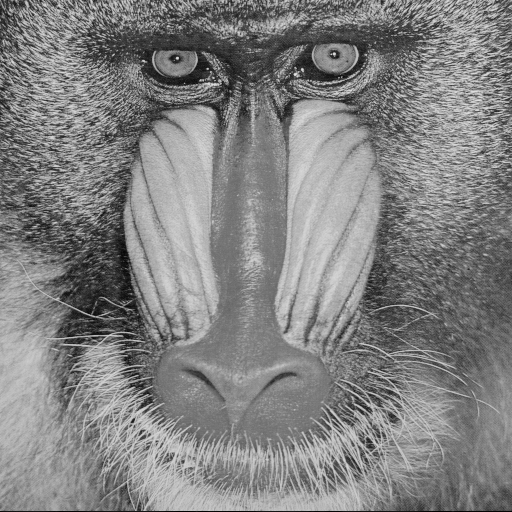

In [107]:
Gray.(new_m_im0)

In [108]:
maximum(0.0031*g_m_im0)

0.007500921164236306

In [109]:
minimum(0.0031*g_m_im0)

-0.009104017589200859

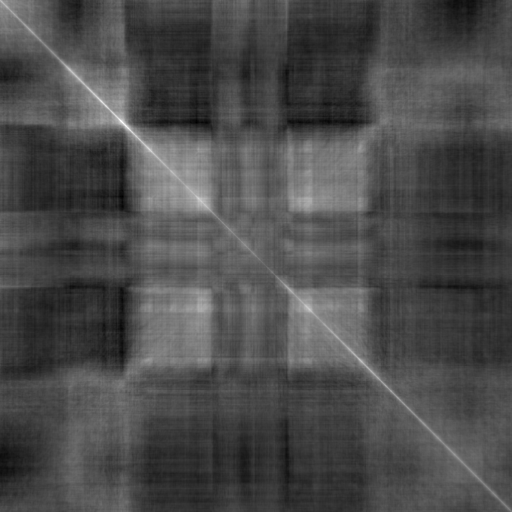

In [110]:
# not much difference in the matrix, let's see what the product is
Gray.(value3(new_m_im0))

In [111]:
# the product did change, but mostly became a bit lighter

# let's proceed manually a bit more

In [112]:
grads_n1 = gradient(()->loss(new_m_im0, p_m_im0_warped_norm), params(new_m_im0))

Grads(...)

In [114]:
g1_m_im0 = grads_n1[new_m_im0]

512×512 Matrix{Float64}:
 -0.000268833   0.000379431   0.00071053   …  -0.00113183   -0.00166497
 -0.000769161  -0.000123657  -0.000133976     -0.000688323  -0.00116151
 -0.00119578   -0.000548492  -0.000714158     -0.000783268  -0.0011519
 -0.00146504   -0.00077154   -0.000819151     -0.000785273  -0.000966509
 -0.00129985   -0.000818091  -0.000555209     -0.000477299  -0.000479095
 -0.00145804   -0.00101821   -0.000175623  …   0.000106502  -3.30245e-6
 -0.00194797   -0.00136614   -0.000305918      0.00112959    0.000772059
 -0.00205642   -0.00156607   -0.000526327      0.00103742    0.000616649
 -0.00189063   -0.00136565   -0.000772389      0.000631894   0.000321858
 -0.00140832   -0.000912163  -0.00053202      -0.000299569  -0.000456408
 -0.00133639   -0.000679385  -0.000269373  …  -0.000534939  -0.000862495
 -0.00167458   -0.000960874  -0.000580669     -0.000137852  -0.00052565
 -0.00162432   -0.00102738   -0.000637235     -3.19818e-5   -0.000533801
  ⋮                             

In [136]:
loss(new_m_im0 .- 0.0063*g1_m_im0, p_m_im0_warped_norm)

18.184408041457445

In [137]:
# 0.0063 gives approximately the best loss after one step (manual search along 1D)
v2_m_im0 = new_m_im0 .- 0.0063*g1_m_im0

512×512 Matrix{Float64}:
 0.568629  0.219604   0.19215    0.349022   …  0.443135  0.600009   0.694132
 0.454907  0.396078   0.156862   0.262752      0.5098    0.584318   0.490204
 0.301969  0.447061   0.180396   0.180401      0.392154  0.345102   0.317654
 0.278442  0.533338   0.372554   0.188245      0.286273  0.294121   0.274515
 0.341186  0.478436   0.51765    0.196089      0.231369  0.313727   0.337256
 0.32158   0.298046   0.623529   0.239225   …  0.333324  0.596075   0.713723
 0.168641  0.200009   0.525489   0.509806      0.725471  0.776456   0.643126
 0.129426  0.20001    0.435295   0.599999      0.631351  0.470574   0.541166
 0.223543  0.188244   0.219611   0.458827      0.529396  0.611755   0.478424
 0.149029  0.125496   0.188237   0.250984      0.254894  0.317646   0.533334
 0.12942   0.16863    0.223528   0.145102   …  0.254893  0.286275   0.26667
 0.129422  0.184318   0.305883   0.141184      0.349008  0.290192   0.294117
 0.141186  0.262749   0.352942   0.254908      0.301

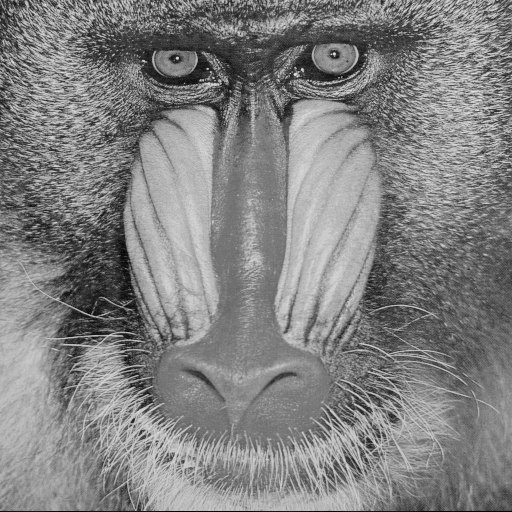

In [138]:
Gray.(v2_m_im0)

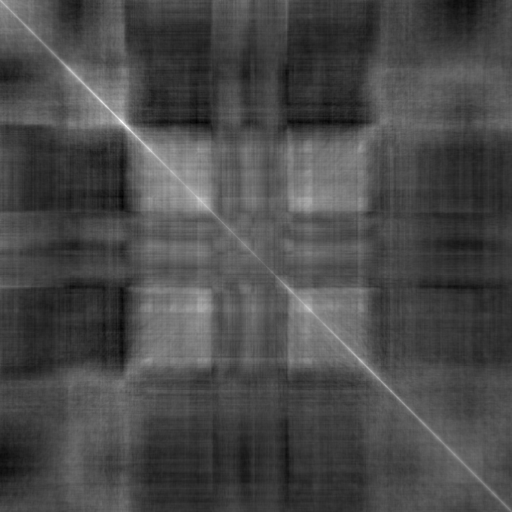

In [140]:
# not much difference in the matrix, let's see what the product is
Gray.(value3(v2_m_im0))

In [141]:
# the visual difference is less than in the previous iteration, just like the loss difference is less
maximum(0.0063*g1_m_im0)

0.004971504271352077

In [142]:
minimum(0.0063*g1_m_im0)

-0.004137564002729013

In [143]:
grads_n2 = gradient(()->loss(v2_m_im0, p_m_im0_warped_norm), params(v2_m_im0))

Grads(...)

In [144]:
g2_m_im0 = grads_n2[v2_m_im0]

512×512 Matrix{Float64}:
 -7.08401e-5    0.000591419   0.000915771  …  -0.0011272    -0.00166359
 -0.000435829   0.000217037   0.000201203     -0.000554872  -0.00102922
 -0.000802645  -0.000154493  -0.00033027      -0.000608956  -0.000982068
 -0.00105696   -0.00036386   -0.000427573     -0.000610936  -0.00080119
 -0.000939873  -0.000458602  -0.000223312     -0.000362682  -0.000376979
 -0.00109523   -0.00064882    0.000154311  …   0.000177661   5.53405e-5
 -0.00144833   -0.00086359    0.000151125      0.00133177    0.000967953
 -0.00152478   -0.00102989   -3.41473e-5       0.00127229    0.000846297
 -0.00143592   -0.000903169  -0.000344537      0.000801242   0.000483352
 -0.000974361  -0.000469898  -0.000121781     -0.000145903  -0.000316594
 -0.000817423  -0.000156795   0.00021869   …  -0.000314798  -0.00065187
 -0.00110021   -0.000386524  -4.4437e-5        0.000164256  -0.00022853
 -0.00100519   -0.00040905   -6.11985e-5       0.000323233  -0.000183611
  ⋮                             

In [170]:
loss(v2_m_im0 .- 0.0051*g2_m_im0, p_m_im0_warped_norm)

18.06046187156968

In [171]:
v3_m_im0 = v2_m_im0 .- 0.0063*g2_m_im0

512×512 Matrix{Float64}:
 0.56863    0.2196     0.192144   …  0.443133   0.600016  0.694142
 0.45491    0.396076   0.156861      0.509798   0.584321  0.490211
 0.301974   0.447062   0.180398      0.392154   0.345106  0.317661
 0.278449   0.53334    0.372556      0.286272   0.294125  0.27452
 0.341192   0.478439   0.517651      0.231368   0.313729  0.337259
 0.321587   0.29805    0.623528   …  0.333319   0.596073  0.713722
 0.16865    0.200014   0.525488      0.72546    0.776447  0.64312
 0.129436   0.200017   0.435295      0.631338   0.470566  0.541161
 0.223552   0.18825    0.219614      0.529387   0.61175   0.478421
 0.149036   0.125498   0.188238      0.25489    0.317647  0.533336
 0.129425   0.168631   0.223527   …  0.254888   0.286277  0.266674
 0.129429   0.18432    0.305883      0.349002   0.290191  0.294119
 0.141192   0.262752   0.352942      0.301943   0.372541  0.403922
 ⋮                                ⋱             ⋮         
 0.635287   0.627454   0.560792   …  0.352974  

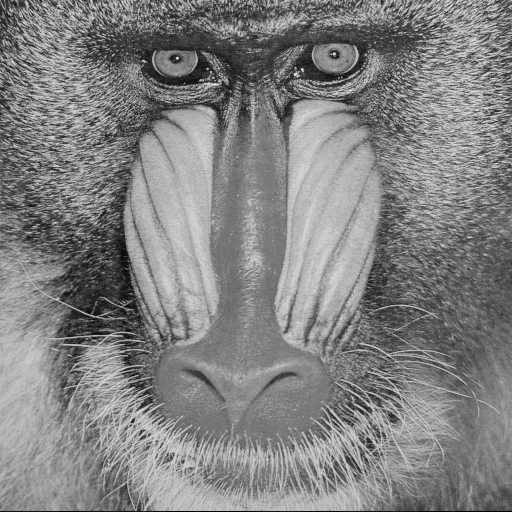

In [172]:
Gray.(v3_m_im0)

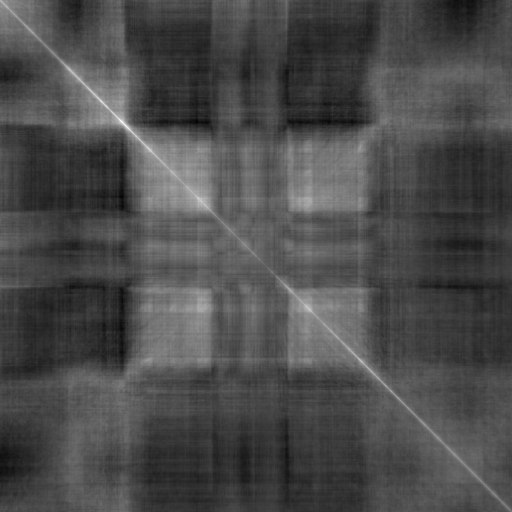

In [173]:
Gray.(value3(v3_m_im0))

In [174]:
maximum(0.0051*g2_m_im0)

0.0024334739650384127

In [175]:
minimum(0.0051*g2_m_im0)

-0.002901058113074577

In [176]:
# so, gradient works in this schema, but it is clear that it converges to a local min, and not to the solution
loss(m_im0_warped, p_m_im0_warped_norm)

0.0